In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from utils import NUM_CLASSES, onehot_converter, data_reader, plot_accuracies, plot_conf_mat

data, labels = data_reader()

100%|██████████| 250/250 [00:09<00:00, 25.91it/s]


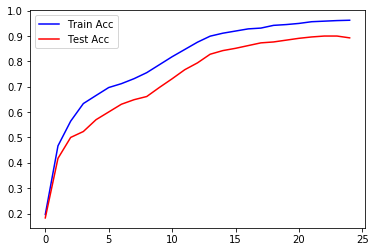

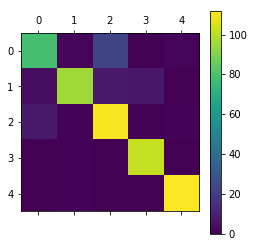

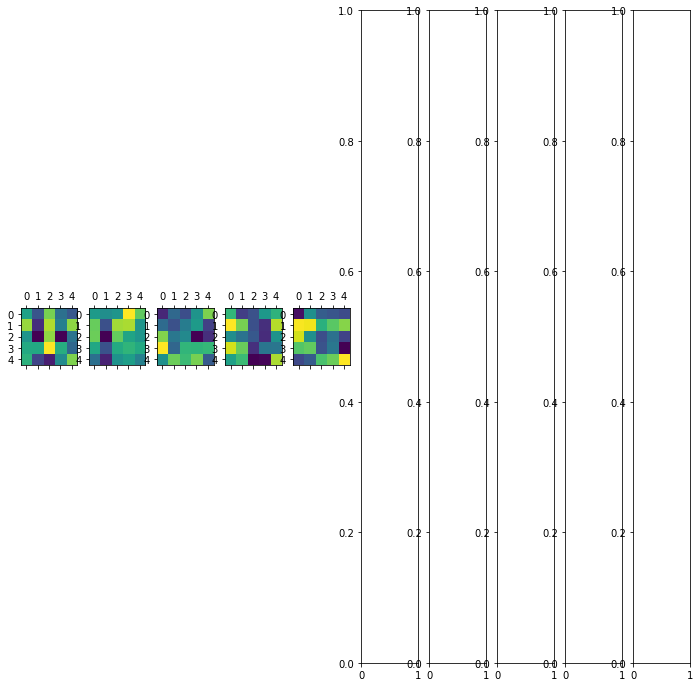

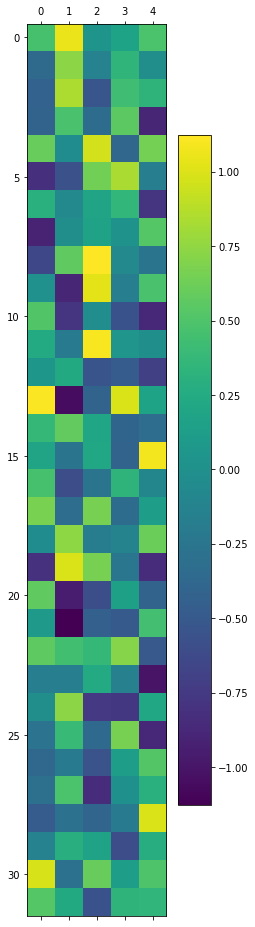

In [8]:
onehot = onehot_converter(labels)

indices = np.random.permutation(data.shape[0])
valid_cnt = int(data.shape[0] * 0.2)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
onehot_test, onehot_train = onehot[test_idx, :], onehot[training_idx, :]

test, train = data[test_idx, :], data[training_idx, :]
size = train.shape[1]
size2 = size*size
test, train = map(lambda x: x.reshape([-1, size2]),
                  [test, train])

x_im = tf.placeholder(tf.float32, [None, size, size, 1])
y = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# First convolutional layer
num_filters = 5
win_size = 5
W1 = tf.Variable(tf.truncated_normal([win_size, win_size, 1, num_filters],
                                     stddev=1./win_size))
b1 = tf.Variable(num_filters*[0.1])

# 5x5 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1,
                  strides=[1, 1, 1, 1],
                  padding='SAME')
h1 = tf.nn.relu(xw + b1)

# 2x2 Max-Pooling (no padding on edges)
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1],
                    padding='VALID')

# Need to flatten convolutional output for use in dense layer
p1_size = np.product([s.value for s in p1.get_shape()[1:]])
p1f = tf.reshape(p1, [-1, p1_size])

# Second (fully connected) layer
num_hidden = 32
W2 = tf.Variable(tf.truncated_normal([p1_size, num_hidden],
                                     stddev=2./np.sqrt(p1_size)))
b2 = tf.Variable(num_hidden*[0.2])
h2 = tf.sigmoid(tf.matmul(p1f, W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal([num_hidden, NUM_CLASSES],
                                     stddev=1./np.sqrt(NUM_CLASSES)))
b3 = tf.Variable(NUM_CLASSES*[0.1])

preds = tf.nn.softmax(tf.matmul(h2, W3) + b3)

cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y)
)

train_step = (tf.train
              .AdamOptimizer()
              .minimize(cross_entropy))

correct_prediction = tf.equal(tf.argmax(preds, 1),
                              tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))


epochs = 250
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm(range(epochs)):
        if i % 10 == 0:
            # Training set
            A = accuracy.eval(
                feed_dict={x_im: train.reshape([-1, size, size, 1]),
                           y: onehot_train})
            train_acc[i//10] = A
            
            # Validation set
            A = accuracy.eval(
                feed_dict={x_im: test.reshape([-1, size, size, 1]),
                           y: onehot_test})
            test_acc[i//10] = A
            
        train_step.run(
            feed_dict={x_im: train.reshape([-1, size, size, 1]),
                       y: onehot_train})

    # Plot the accuracy curves
    plot_accuracies(train_acc, test_acc)
    
    # Look at the final testing confusion matrix
    predicted_classes = np.argmax(
        preds.eval(feed_dict={x_im: test.reshape([-1, size, size, 1]),
                             y: onehot_test}),
        axis=1)
    plot_conf_mat(predicted_classes, labels[test_idx])

    # Plot the weights (of the filters)
    f, plts = plt.subplots(ncols=)
    f.set_size_inches(12, 12)
    W1_ = W1.eval()
    for i in range(num_filters):
        plts[i].matshow(W1_[:, :, 0, i])
    f.show()
    
    # Plot the output weights
    plt.matshow(W3.eval())
    plt.colorbar()
